# 📊 Análisis Post-Modelo del Dataset

En esta sección se analiza el desempeño del modelo final sobre el **conjunto de test**, centrándonos en:

- Evaluar cómo funciona el modelo globalmente
- Analizar el rendimiento por grupos académicos (titulación, etapa y subetapa)
- Detectar posibles sesgos o áreas con bajo desempeño
- Generar alertas y recomendaciones para la mejora del modelo o la recolección de datos

El objetivo es entender no solo **qué tan preciso es el modelo**, sino **dónde funciona mejor y dónde falla**.

---

## 1️⃣ Carga del Modelo Final y del Conjunto de Test

- El modelo ya entrenado se carga desde el almacenamiento definido (`modelo_final_explicable`).  
- Se extrae el conjunto de test correspondiente al **último curso académico** para garantizar que los datos no hayan sido vistos durante el entrenamiento.  
- Se preparan las variables de modelado y el target para la predicción.

📌 Esto asegura que las métricas calculadas reflejen el **rendimiento real del modelo** sobre datos nuevos.

---

## 2️⃣ Predicciones del Modelo

- Se calculan:

  - **Etiquetas predichas** (`prediction_label`)  
  - **Probabilidades de éxito** (`prediction_score`)

- Se reengancha el target real para poder comparar las predicciones con los resultados reales.  

📌 Esto permite calcular métricas como **Accuracy** y **AUC** tanto de forma global como por grupos.

---

## 3️⃣ Análisis por Grupos Académicos

Se realiza un desglose del desempeño del modelo por:

1. **Titulación (`TITULACION`)**
2. **Etapa (`PL_ETAPA`)**
3. **Subetapa (`PL_SUBETAPA`)**, si existe en el dataset

Para cada grupo se calcula:

- Número de observaciones (`n`)  
- **Accuracy**: porcentaje de aciertos  
- **AUC**: capacidad del modelo para discriminar entre clases

Además, se identifican automáticamente los **5 mejores y 5 peores grupos** según Accuracy.

---

## 4️⃣ Visualización de Resultados

- Se generan **gráficos de barras** mostrando los grupos con mejor desempeño.  
- Esto permite identificar visualmente:

  - Qué titulaciones, etapas o subetapas presentan mayor confiabilidad en las predicciones
  - Qué grupos podrían requerir atención o revisión de datos

📌 La visualización facilita la interpretación de los resultados por stakeholders académicos.

---

## 5️⃣ Alertas y Recomendaciones Automáticas

- Se generan alertas para grupos con **Accuracy por debajo de un umbral configurable** (por ejemplo, 0.7).  
- Esto ayuda a:

  - Detectar titulaciones o etapas donde el modelo es menos fiable  
  - Tomar decisiones sobre **recolección de datos adicional** o **revisión de características del grupo**  
  - Priorizar intervenciones en los grupos con peor desempeño

---

## 6️⃣ Interpretación de Resultados

- Los grupos con **Accuracy alta (>0.9)** indican que el modelo predice muy bien el éxito de los candidatos.  
- Los grupos con **Accuracy baja (<0.6–0.7)** requieren atención, ya que el modelo podría estar sesgado o los datos ser insuficientes o ruidosos.  
- El análisis por **AUC** complementa el análisis de Accuracy, mostrando la capacidad de discriminación del modelo incluso si los grupos son desbalanceados.

---

## 7️⃣ Beneficios de Este Análisis

- Permite evaluar el **rendimiento real del modelo** más allá de las métricas globales.  
- Facilita la identificación de **sesgos por segmentación académica**.  
- Proporciona información clave para mejorar:

  - Estrategias de admisión o seguimiento de candidatos  
  - Preparación de submodelos específicos por áreas  
  - Recolección y limpieza de datos en grupos críticos  

📌 Los resultados obtenidos en esta fase **cierran el ciclo de modelado**, conectando la predicción con decisiones operativas y estratégicas.


---


Transformation Pipeline and Model Successfully Loaded
✅ Modelo cargado correctamente.
⚠️ No hay cursos válidos. Se usará todo el dataset de test.
✅ Filas de test después de eliminar NaN en target: 536598
✅ Predicciones realizadas. Número de filas: 536598

📊 Resultados por TITULACION (Top 5 oportunidades):
                                           TITULACION      n    AUC  Accuracy  \
0  Grado en Gestión Aplicada / Bachelor in Applie...  10593  0.394     0.983   
1                                Grado en Psicología  19712  0.373     0.981   
2                  Grado en Estudios de Arquitectura  16705  0.381     0.980   
3                                  Grado en Medicina  45177  0.311     0.980   
4                                Grado en Enfermería  16018  0.340     0.963   

   Accuracy_0  Accuracy_1  
0       0.980       0.986  
1       0.979       0.986  
2       0.981       0.978  
3       0.984       0.961  
4       0.966       0.959  

⚠️ Peores 5 TITULACION (Top 5 oportunidade

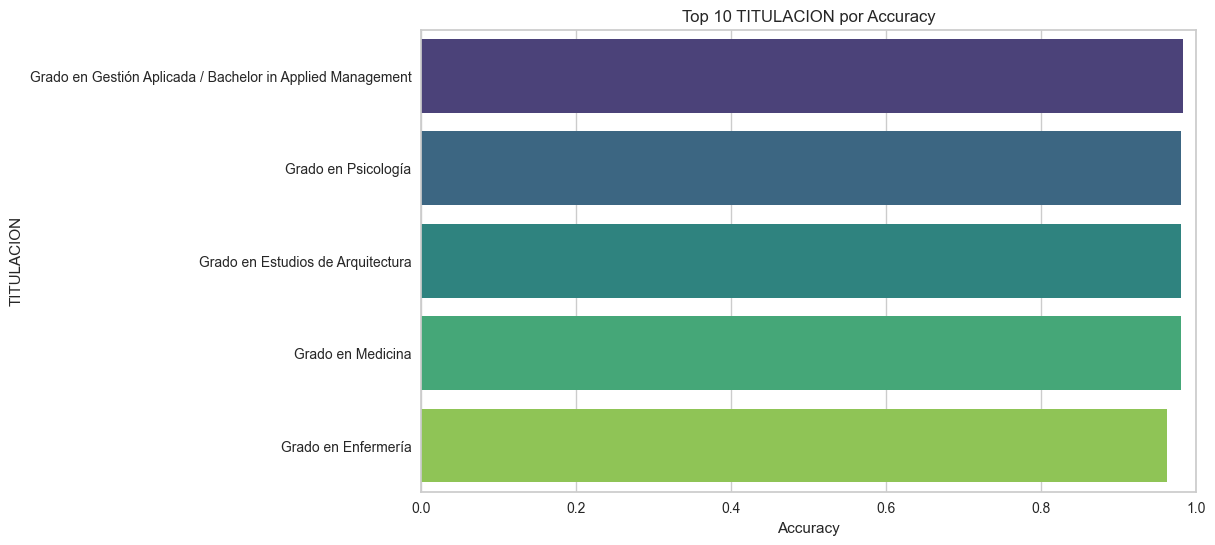


✅ Todos los TITULACION tienen Accuracy >= 0.7

⚠️ No hay columna 'ETAPA_SUBETAPA' para análisis.

✅ Análisis post-modelo completado con accuracy por clase y sin errores de NaN.


In [5]:
# ============================================================
# SCRIPT POST-MODELO COMPLETO CON ACCURACY POR CLASE (CORREGIDO)
# ============================================================

import pandas as pd
import numpy as np
from pycaret.classification import load_model, predict_model
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 0️⃣ CARGA DEL MODELO
# ============================================================
ruta_modelo = r"..\datos\04. Modelos\modelo_final_grado"
modelo = load_model(ruta_modelo)
print("✅ Modelo cargado correctamente.")

# ============================================================
# 1️⃣ CARGA DEL DATASET DE TEST
# ============================================================
ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

# Convertir PL_CURSO_ACADEMICO a numérico
df['PL_CURSO_ACADEMICO'] = pd.to_numeric(df['PL_CURSO_ACADEMICO'], errors='coerce')

# Filtrar por curso académico más reciente
if df['PL_CURSO_ACADEMICO'].dropna().empty:
    test_df_full = df.copy()
    print("⚠️ No hay cursos válidos. Se usará todo el dataset de test.")
else:
    ultimo_curso = df['PL_CURSO_ACADEMICO'].max()
    test_df_full = df[df['PL_CURSO_ACADEMICO'] == ultimo_curso].copy()
    print(f"✅ Datos de test filtrados por curso {ultimo_curso}. Filas: {len(test_df_full)}")

# ============================================================
# 2️⃣ FILTRAR NAs DEL TARGET
# ============================================================
test_df_full = test_df_full.dropna(subset=[target]).reset_index(drop=True)
test_df_full[target] = test_df_full[target].astype(int)  # 🔹 Asegurar binario
print(f"✅ Filas de test después de eliminar NaN en target: {len(test_df_full)}")

# ============================================================
# 3️⃣ VARIABLES DEL MODELO
# ============================================================
vars_excluir = [
    target, 'desmatriculado', 'MINIMUMPAYMENTPAYED',
    'CH_PAGO_SUPERIOR', 'STAGENAME', 'PL_SUBETAPA',
    'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NAMEX', 'YEARPERSONBIRTHDATE'
]

test_X = test_df_full[[c for c in test_df_full.columns if c not in vars_excluir]].copy()
test_y = test_df_full[target].reset_index(drop=True)

# ============================================================
# 4️⃣ RECONSTRUIR FLAGS DE NA Y RELLENAR NAs
# ============================================================
vars_cero_logico = [
    'NU_NOTA_MEDIA_ADMISION',
    'NU_NOTA_MEDIA_1_BACH__PC',
    'NU_RESULTADO_ADMISION_PUNTOS',
    'CU_IMPORTE_TOTAL',
    'CU_precioOrdinario_def__c',
    'CU_precioAplicado_def__c'
]

for v in vars_cero_logico:
    if v in test_X.columns:
        test_X[f'flag_{v}_na'] = test_X[v].isna().astype(int)
        test_X[v] = test_X[v].fillna(0)

# Rellenar cualquier otro NA restante con 0
test_X = test_X.fillna(0)

# ============================================================
# 5️⃣ PREDICCIONES
# ============================================================
preds = predict_model(modelo, data=test_X)
preds[target] = test_y  # Reenganchar target real

# 🔹 Asegurar que prediction_score corresponde a target=1
if 'prediction_score' not in preds.columns:
    preds['prediction_score'] = preds['Score']  # Ajuste por versiones PyCaret
preds['probabilidad_matricula'] = preds['prediction_score']  # ✅ Probabilidad de matrícula

# Añadir columnas originales para análisis posterior
for col in ['TITULACION', 'PL_ETAPA', 'PL_SUBETAPA']:
    if col in test_df_full.columns:
        preds[col] = test_df_full[col].values

# Crear columna combinada ETAPA + SUBETAPA
if 'PL_ETAPA' in preds.columns and 'PL_SUBETAPA' in preds.columns:
    preds['ETAPA_SUBETAPA'] = preds['PL_ETAPA'].astype(str) + " - " + preds['PL_SUBETAPA'].astype(str)

print(f"✅ Predicciones realizadas. Número de filas: {len(preds)}")

# ============================================================
# 6️⃣ FUNCIONES DE ANÁLISIS
# ============================================================
def analizar_grupo(df, grupo_col, top=5):
    res = []
    for grupo, g in df.groupby(grupo_col):
        if g[target].nunique() == 0:
            continue
        auc = roc_auc_score(g[target], g['prediction_score']) if g[target].nunique() > 1 else np.nan
        acc = accuracy_score(g[target], g['prediction_label'])
        acc_0 = (g[g[target] == 0]['prediction_label'] == 0).mean() if (g[target] == 0).sum() > 0 else np.nan
        acc_1 = (g[g[target] == 1]['prediction_label'] == 1).mean() if (g[target] == 1).sum() > 0 else np.nan

        res.append({
            grupo_col: grupo,
            'n': len(g),
            'AUC': round(auc,3) if not np.isnan(auc) else auc,
            'Accuracy': round(acc,3),
            'Accuracy_0': round(acc_0,3) if not np.isnan(acc_0) else acc_0,
            'Accuracy_1': round(acc_1,3) if not np.isnan(acc_1) else acc_1
        })
    df_res = pd.DataFrame(res).sort_values('Accuracy', ascending=False).reset_index(drop=True)
    return df_res, df_res.head(top), df_res.tail(top)

def plot_top_groups(df, col_name, top=10, metric='Accuracy'):
    df_plot = df.sort_values(metric, ascending=False).head(top)
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_plot, x=metric, y=col_name, palette="viridis")
    plt.title(f"Top {top} {col_name} por {metric}")
    plt.xlim(0,1)
    plt.show()

def alertas_grupo(df, col_name, metric='Accuracy', umbral=0.7):
    alertas = df[df[metric] < umbral]
    if not alertas.empty:
        print(f"\n⚠️ ALERTA: {len(alertas)} {col_name} con {metric} < {umbral}:")
        print(alertas[[col_name, metric, 'n']])
    else:
        print(f"\n✅ Todos los {col_name} tienen {metric} >= {umbral}")

# ============================================================
# 7️⃣ ANÁLISIS POR GRUPO
# ============================================================
# 🔹 Top 5 titulaciones por número de oportunidades (target=1)
top5_titulaciones = preds.groupby('TITULACION')[target].sum().sort_values(ascending=False).head(5).index.tolist()
df_top5 = preds[preds['TITULACION'].isin(top5_titulaciones)]

# Analizar top 5 titulaciones y ETAPA + SUBETAPA
cols_para_analisis = ['TITULACION', 'ETAPA_SUBETAPA']
for col in cols_para_analisis:
    if col in df_top5.columns:
        df_group, mejores, peores = analizar_grupo(df_top5, col)
        print(f"\n📊 Resultados por {col} (Top 5 oportunidades):\n", mejores)
        print(f"\n⚠️ Peores 5 {col} (Top 5 oportunidades):\n", peores)
        plot_top_groups(df_group, col)
        alertas_grupo(df_group, col, metric='Accuracy', umbral=0.7)
    else:
        print(f"\n⚠️ No hay columna '{col}' para análisis.")

print("\n✅ Análisis post-modelo completado con accuracy por clase y sin errores de NaN.")


🔹 Iniciando análisis de explicabilidad y comparación de variables...
⚠️ La longitud de las importancias (15) no coincide con el número de columnas de X (49).

📊 PDP + ICE para CH_NACIONAL
⚠️ No se pudo generar PDP/ICE para CH_NACIONAL: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ACCOUNTID
- CENTROENSENANZA
- CH_AYUDA_FINANCIACION
- CH_ENTREVISTA_PERSONAL__PC
- CH_FAMILIA_NUMEROSA__PC
- ...


📊 PDP + ICE para ID18__PC
⚠️ No se pudo generar PDP/ICE para ID18__PC: The column #0 contains mixed data types. Finding unique categories fail due to sorting. It usually means that the column contains `np.nan` values together with `str` categories. Such use case is not yet supported in scikit-learn.

📊 PDP + ICE para PL_RESOLUCION_DEFINITIVA
⚠️ No se pudo generar PDP/ICE para PL_RESOLUCION_DEFINITIVA: The column #0 contains mixed data types. Finding unique categories fail due to sorting. It usually means that the column contains `np.nan` val

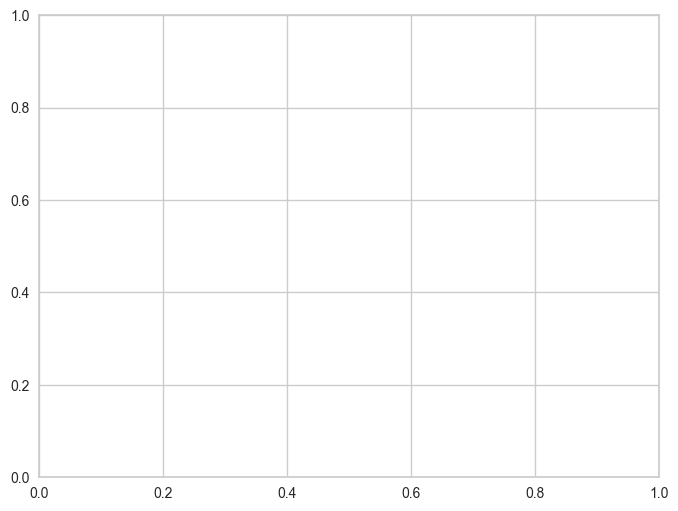

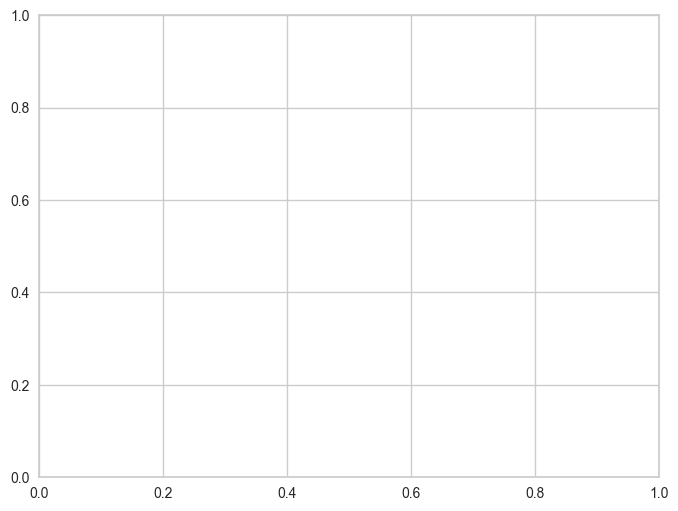

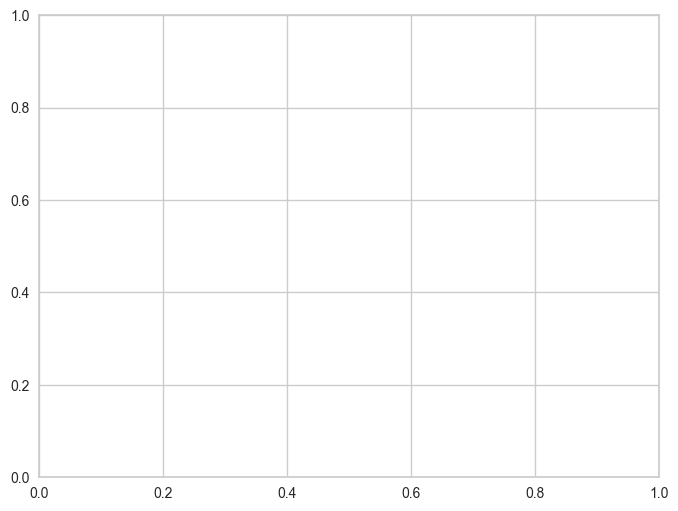

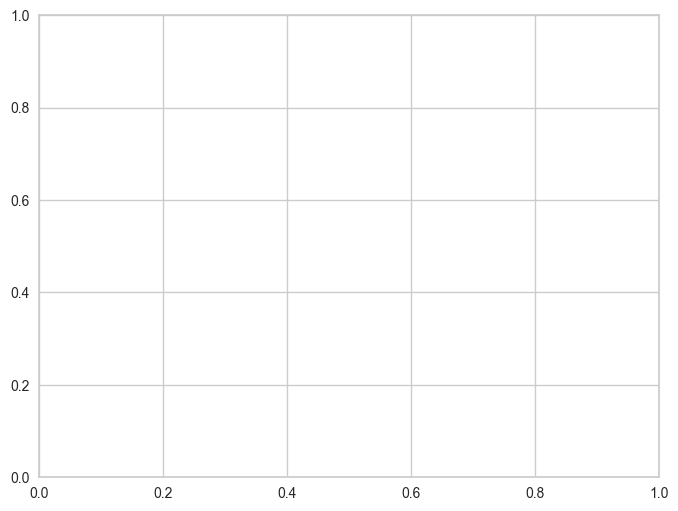

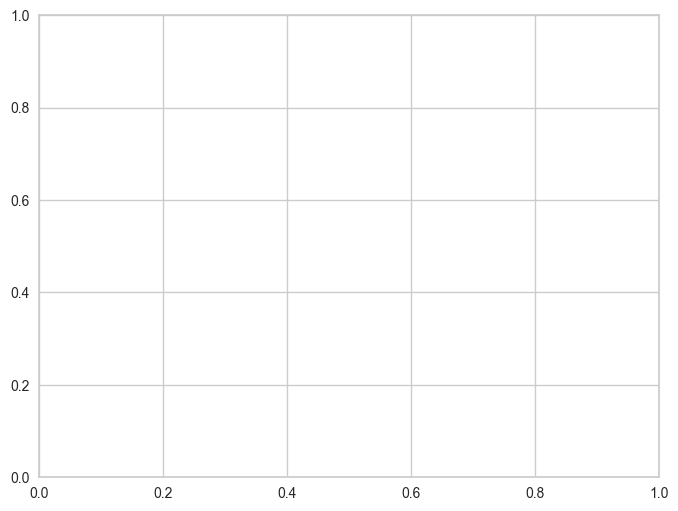

In [7]:
# ============================================================
# 9️⃣ ANÁLISIS DE EXPLICABILIDAD Y COMPARACIÓN GRADO vs MÁSTER
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay

print("🔹 Iniciando análisis de explicabilidad y comparación de variables...")

# ---------------------------
# 1️⃣ Importancia de variables
# ---------------------------
def plot_importancia(modelo, X, top=20, titulo="Importancia de Variables"):
    """
    Grafica la importancia de variables del modelo (feature_importances_ o coef_).
    Retorna DataFrame con columnas: ['Variable', 'Importancia']
    """
    if hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_
    elif hasattr(modelo, 'coef_'):
        importancias = np.abs(modelo.coef_).flatten()
    else:
        print("⚠️ Este modelo no tiene atributo feature_importances_ ni coef_")
        return None
    
    # Asegurarnos de que X y la importancia tengan la misma longitud
    if len(importancias) != X.shape[1]:
        print(f"⚠️ La longitud de las importancias ({len(importancias)}) no coincide con el número de columnas de X ({X.shape[1]}).")
        return None
    
    df_imp = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias})
    df_imp = df_imp.sort_values('Importancia', ascending=False).head(top)
    
    plt.figure(figsize=(10,6))
    sns.barplot(data=df_imp, x='Importancia', y='Variable', palette="viridis")
    plt.title(titulo)
    plt.show()
    
    return df_imp

# ---------------------------
# 2️⃣ PDP + ICE
# ---------------------------
# Juan: Los gráficos que muestras son de importancia de variables. Te dejo documentación para que veas lo que es
# un gráfico PDP e ICE y que se puede hacer con sklearn y pyplot, etc: https://cienciadedatos.net/documentos/py16-interpretacion-modelos-graficos-pdp-ice
def graficos_pdp_ice(modelo, X, features=None, top=5):
    """
    Genera gráficos PDP e ICE para las variables más importantes.
    """
    if features is None:
        # Tomar top variables según importancia si no se especifican
        if hasattr(modelo, 'feature_importances_'):
            imp = modelo.feature_importances_
        elif hasattr(modelo, 'coef_'):
            imp = np.abs(modelo.coef_).flatten()
        else:
            print("⚠️ Modelo no tiene importancias.")
            return
        # Seleccionamos indices de top variables
        features = np.array(X.columns)[np.argsort(imp)[-top:]].tolist()
    
    for f in features:
        try:
            print(f"\n📊 PDP + ICE para {f}")
            fig, ax = plt.subplots(figsize=(8,6))
            PartialDependenceDisplay.from_estimator(modelo, X, [f], kind='both', ax=ax)
            plt.show()
        except Exception as e:
            print(f"⚠️ No se pudo generar PDP/ICE para {f}: {e}")

# ---------------------------
# 3️⃣ Comparación con modelo de Grado
# ---------------------------
def comparar_importancia(df_imp_grado, df_imp_master):
    """
    Compara importancia de variables entre Grado y Máster.
    """
    comparacion = pd.merge(
        df_imp_grado, df_imp_master,
        on='Variable',
        how='outer',
        suffixes=('_Grado', '_Master')
    ).fillna(0)

    comparacion['Diferencia'] = comparacion['Importancia_Master'] - comparacion['Importancia_Grado']
    comparacion = comparacion.sort_values('Diferencia', key=abs, ascending=False)

    print("\n📊 Comparación de importancia de variables Grado vs Máster (top 10 por diferencia):")
    print(comparacion.head(10))
    return comparacion

# ---------------------------
# 4️⃣ Ejecutar análisis para Máster
# ---------------------------
df_imp_master = plot_importancia(modelo, test_X, top=20, titulo="Importancia de Variables - Máster")

# PDP + ICE top 5 variables del modelo de Máster
graficos_pdp_ice(modelo, test_X, top=5)

# ---------------------------
# 5️⃣ Ejecutar comparación si df_imp_grado existe
# ---------------------------
if 'df_imp_grado' in globals() and df_imp_grado is not None and df_imp_master is not None:
    comparacion = comparar_importancia(df_imp_grado, df_imp_master)
else:
    print("⚠️ No se puede hacer la comparación. df_imp_grado o df_imp_master no están definidos.")


# Juan: En los resultados no se refleja nada de lo que haces en el chunk, seguramente no lo has lanzado y se quedó cacheado el resultado anterior.

🔹 Iniciando análisis de explicabilidad y comparación de variables...
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
✅ Columnas para Grado: 15
✅ Columnas para Máster: 17


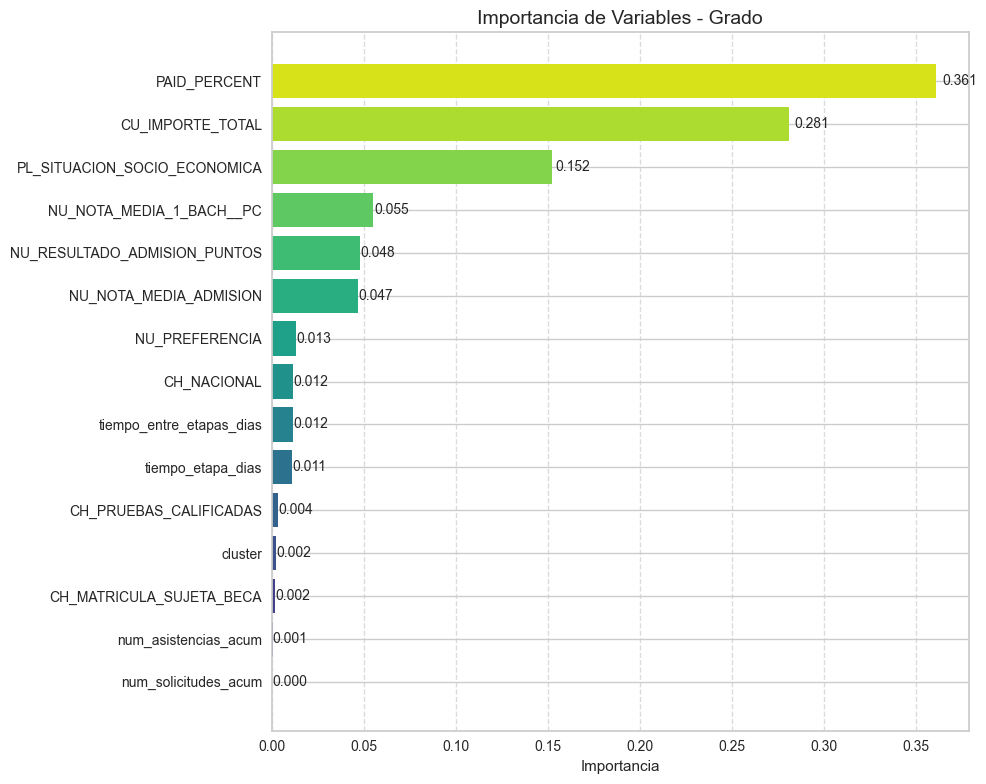


📊 PDP + ICE para NU_RESULTADO_ADMISION_PUNTOS


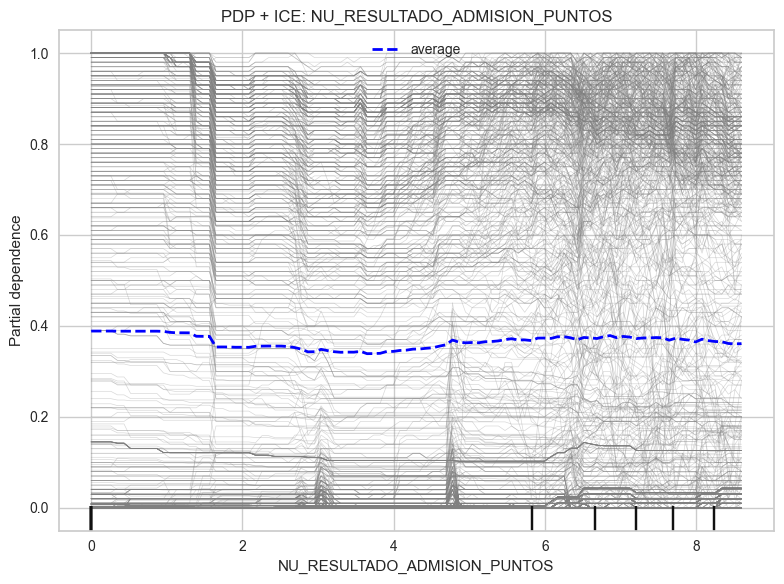


📊 PDP + ICE para NU_NOTA_MEDIA_1_BACH__PC


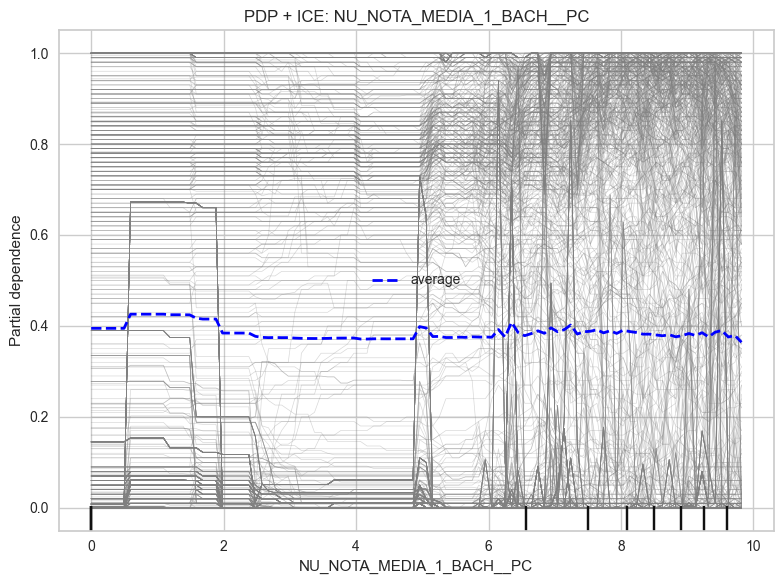


📊 PDP + ICE para PL_SITUACION_SOCIO_ECONOMICA


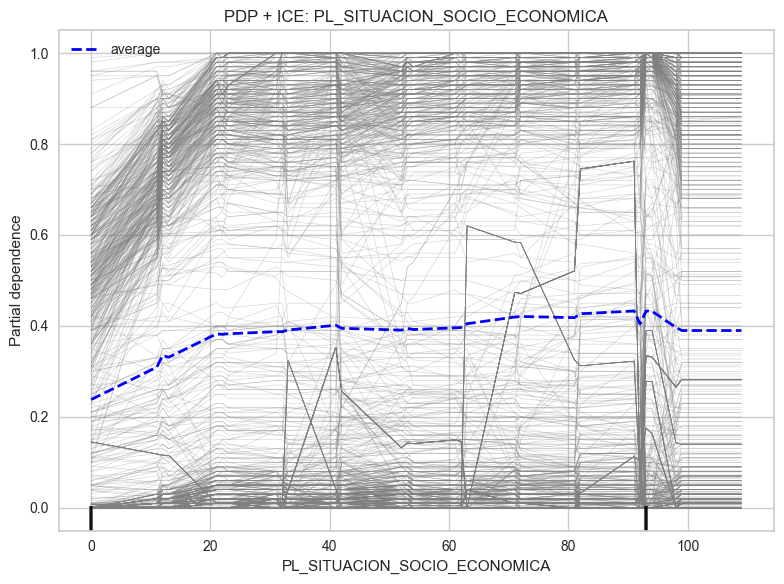


📊 PDP + ICE para CU_IMPORTE_TOTAL


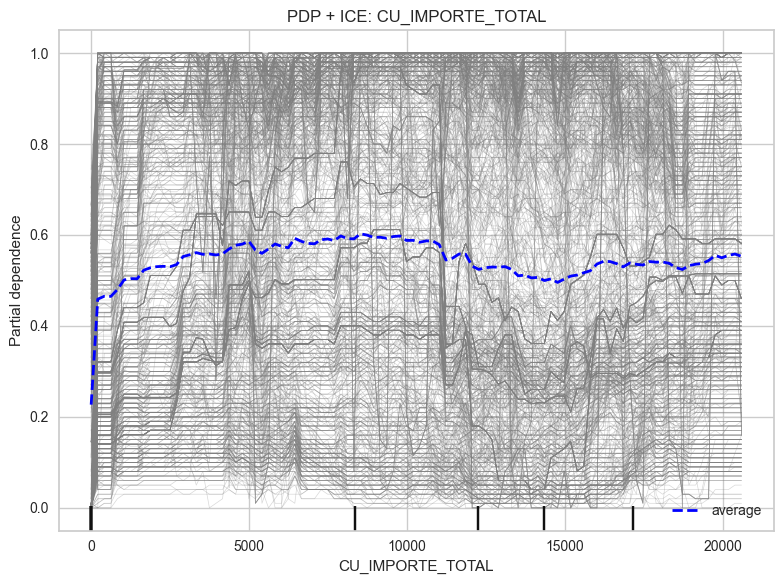


📊 PDP + ICE para PAID_PERCENT


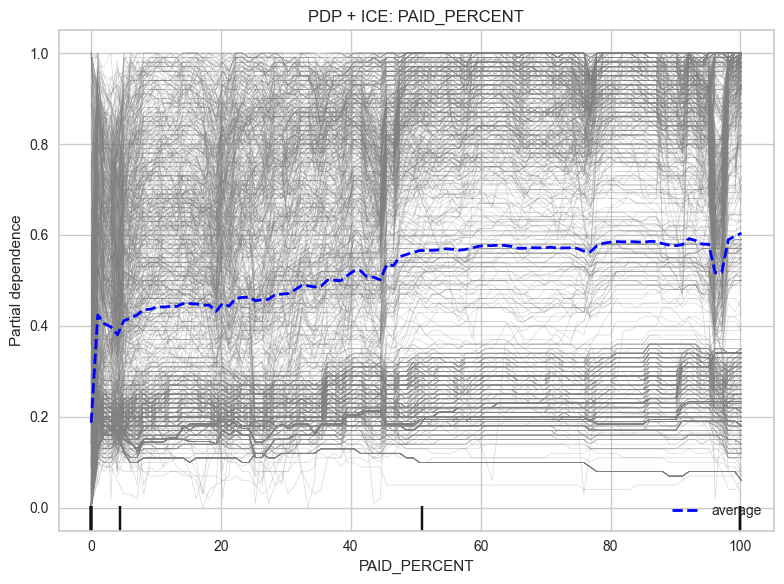

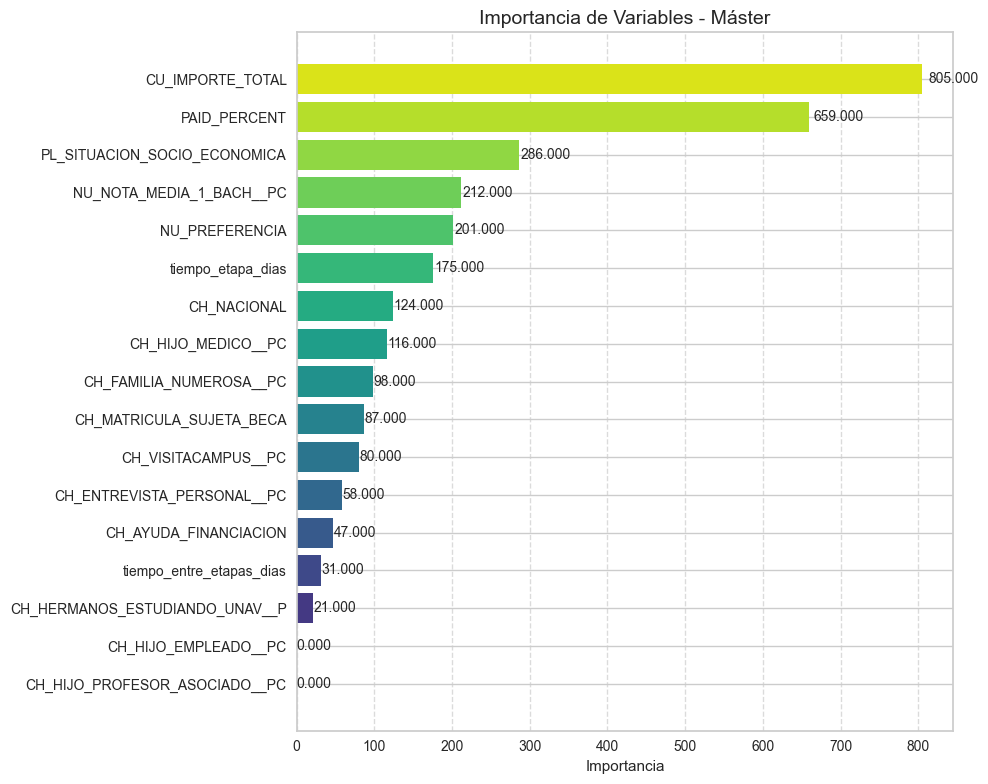


📊 PDP + ICE para NU_PREFERENCIA


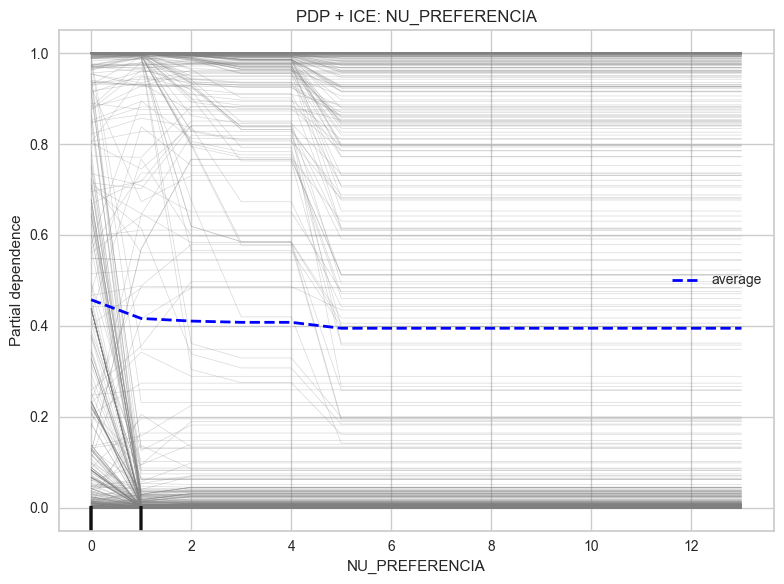


📊 PDP + ICE para NU_NOTA_MEDIA_1_BACH__PC


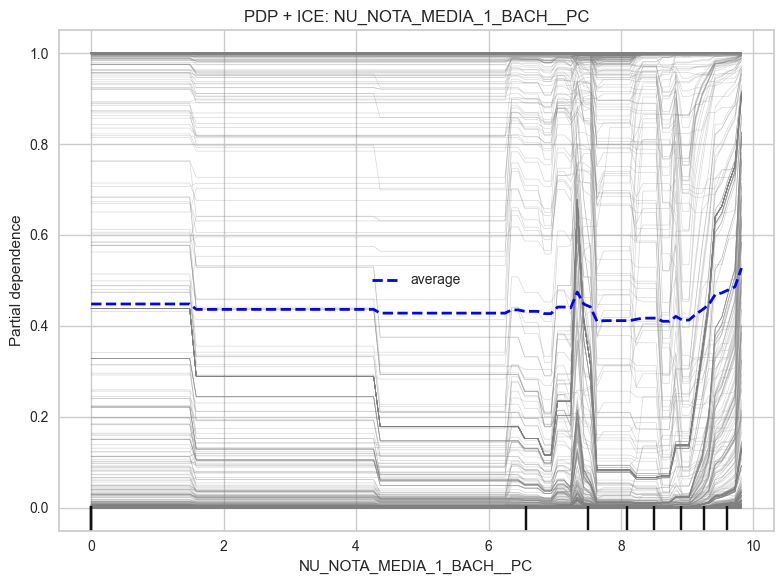


📊 PDP + ICE para PL_SITUACION_SOCIO_ECONOMICA


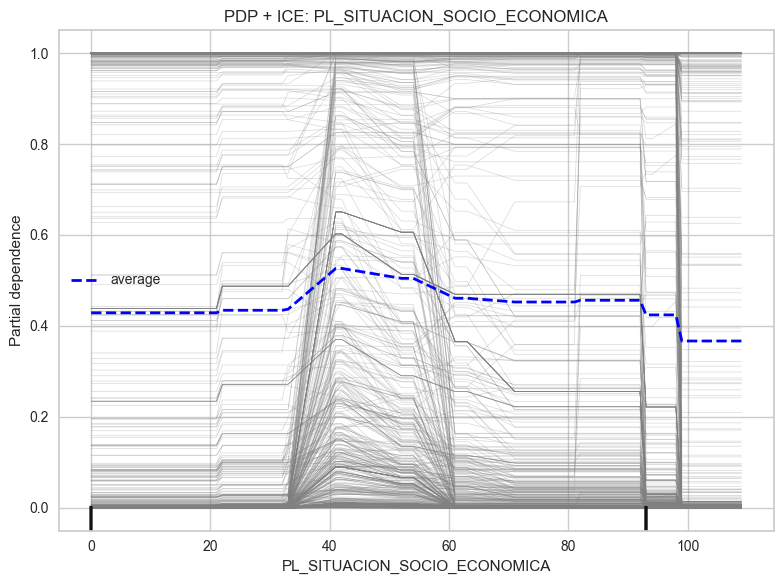


📊 PDP + ICE para PAID_PERCENT


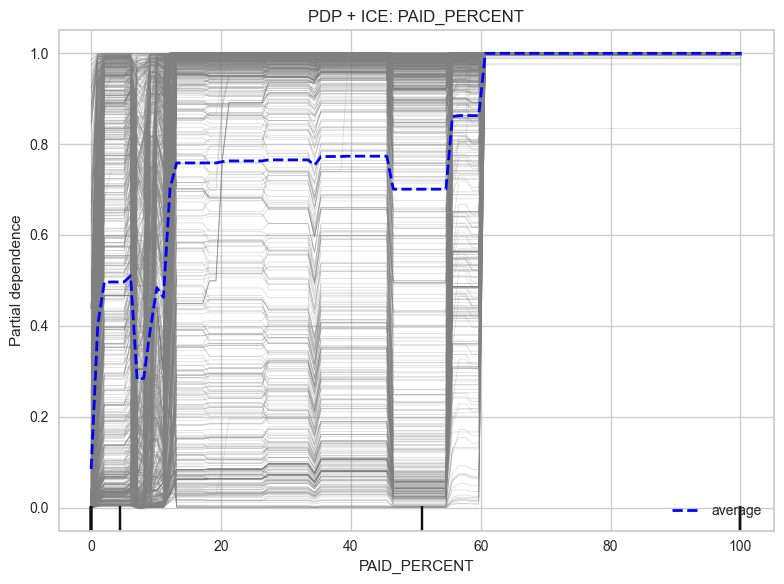


📊 PDP + ICE para CU_IMPORTE_TOTAL


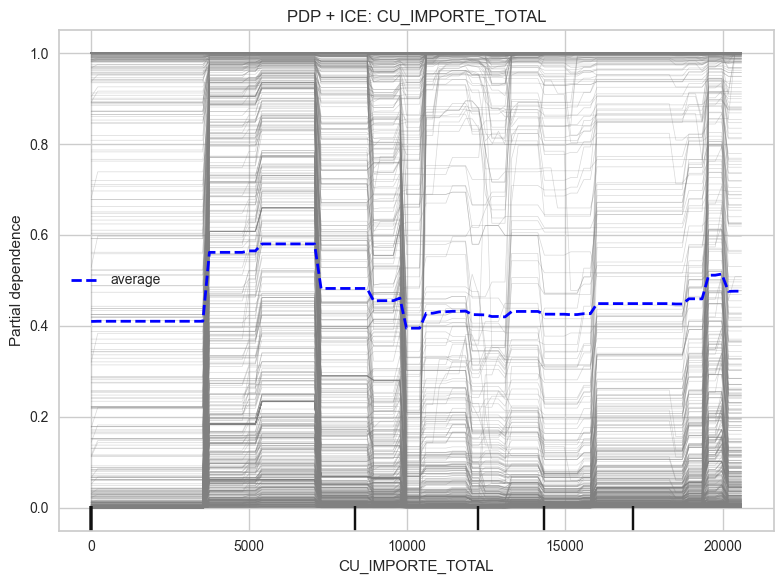

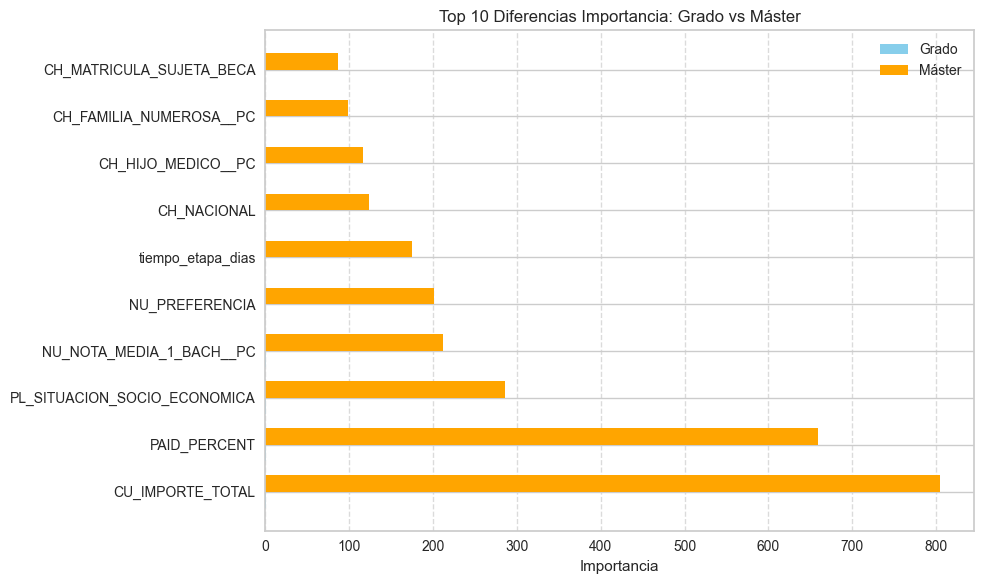


📊 Comparación de importancia de variables Grado vs Máster (top 10 por diferencia):
                        Variable  Importancia_Grado  Importancia_Master  \
13              CU_IMPORTE_TOTAL           0.281245               805.0   
14                  PAID_PERCENT           0.360905               659.0   
12  PL_SITUACION_SOCIO_ECONOMICA           0.152468               286.0   
11      NU_NOTA_MEDIA_1_BACH__PC           0.055148               212.0   
8                 NU_PREFERENCIA           0.013218               201.0   
5              tiempo_etapa_dias           0.010817               175.0   
7                    CH_NACIONAL           0.011741               124.0   
22            CH_HIJO_MEDICO__PC           0.000000               116.0   
21       CH_FAMILIA_NUMEROSA__PC           0.000000                98.0   
2       CH_MATRICULA_SUJETA_BECA           0.001705                87.0   

    Diferencia  
13  804.718755  
14  658.639095  
12  285.847532  
11  211.944852  
8   2

In [3]:
# ============================================================
# 🔹 ANÁLISIS DE EXPLICABILIDAD Y COMPARACIÓN GRADO vs MÁSTER
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
from pycaret.classification import load_model

print("🔹 Iniciando análisis de explicabilidad y comparación de variables...")

# ============================================================
# 0️⃣ CARGA DE MODELOS
# ============================================================
modelo_grado  = load_model(r"..\datos\04. Modelos\modelo_final_grado")
modelo_master = load_model(r"..\datos\04. Modelos\modelo_final_master")

# ============================================================
# 1️⃣ FILTRAR COLUMNAS USADAS POR CADA MODELO
# ============================================================
columnas_grado  = [c for c in modelo_grado.feature_names_in_ if c in test_X.columns]
columnas_master = [c for c in modelo_master.feature_names_in_ if c in test_X.columns]

test_X_grado  = test_X[columnas_grado].copy()
test_X_master = test_X[columnas_master].copy()

print(f"✅ Columnas para Grado: {len(columnas_grado)}")
print(f"✅ Columnas para Máster: {len(columnas_master)}")

# ============================================================
# 2️⃣ FUNCIONES DE ANÁLISIS MEJORADAS
# ============================================================
def plot_importancia(modelo, X, top=20, titulo="Importancia de Variables"):
    """Gráfico horizontal con valores encima y degradado de color"""
    if hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_
    elif hasattr(modelo, 'coef_'):
        importancias = np.abs(modelo.coef_).flatten()
    else:
        print("⚠️ Este modelo no tiene atributo feature_importances_ ni coef_")
        return None

    if len(importancias) != X.shape[1]:
        print(f"⚠️ La longitud de las importancias ({len(importancias)}) no coincide con columnas X ({X.shape[1]}).")
        return None

    df_imp = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias})
    df_imp = df_imp.sort_values('Importancia', ascending=True).tail(top)

    plt.figure(figsize=(10, max(6, top*0.4)))
    colors = sns.color_palette("viridis", len(df_imp))
    bars = plt.barh(df_imp['Variable'], df_imp['Importancia'], color=colors)
    plt.title(titulo, fontsize=14)
    plt.xlabel("Importancia")
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Mostrar valores encima de cada barra
    for bar in bars:
        w = bar.get_width()
        plt.text(w + 0.01*w, bar.get_y() + bar.get_height()/2, f"{w:.3f}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    return df_imp

def graficos_pdp_ice(modelo, X, features=None, top=5):
    """PDP en línea principal y ICE individuales en gris"""
    if features is None:
        if hasattr(modelo, 'feature_importances_'):
            imp = modelo.feature_importances_
        elif hasattr(modelo, 'coef_'):
            imp = np.abs(modelo.coef_).flatten()
        else:
            print("⚠️ Modelo no tiene importancias.")
            return
        features = np.array(X.columns)[np.argsort(imp)[-top:]].tolist()

    for f in features:
        try:
            print(f"\n📊 PDP + ICE para {f}")
            fig, ax = plt.subplots(figsize=(8,6))
            PartialDependenceDisplay.from_estimator(
                modelo, X, [f], kind='both', 
                ice_lines_kw={'color':'gray','alpha':0.3},
                pd_line_kw={'color':'blue','linewidth':2},
                ax=ax
            )
            plt.title(f"PDP + ICE: {f}")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"⚠️ No se pudo generar PDP/ICE para {f}: {e}")

def comparar_importancia(df_imp_grado, df_imp_master):
    comparacion = pd.merge(
        df_imp_grado, df_imp_master,
        on='Variable',
        how='outer',
        suffixes=('_Grado', '_Master')
    ).fillna(0)
    comparacion['Diferencia'] = comparacion['Importancia_Master'] - comparacion['Importancia_Grado']
    comparacion = comparacion.sort_values('Diferencia', key=abs, ascending=False)

    # Gráfico comparativo de barras
    plt.figure(figsize=(10,6))
    comparacion_top = comparacion.head(10)
    x = np.arange(len(comparacion_top))
    width = 0.35
    plt.barh(x - width/2, comparacion_top['Importancia_Grado'], width, label='Grado', color='skyblue')
    plt.barh(x + width/2, comparacion_top['Importancia_Master'], width, label='Máster', color='orange')
    plt.yticks(x, comparacion_top['Variable'])
    plt.xlabel("Importancia")
    plt.title("Top 10 Diferencias Importancia: Grado vs Máster")
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n📊 Comparación de importancia de variables Grado vs Máster (top 10 por diferencia):")
    print(comparacion_top[['Variable','Importancia_Grado','Importancia_Master','Diferencia']])
    return comparacion

# ============================================================
# 3️⃣ EJECUTAR ANÁLISIS PARA GRADO
# ============================================================
df_imp_grado = plot_importancia(modelo_grado, test_X_grado, top=20, titulo="Importancia de Variables - Grado")
graficos_pdp_ice(modelo_grado, test_X_grado, top=5)

# ============================================================
# 4️⃣ EJECUTAR ANÁLISIS PARA MÁSTER
# ============================================================
df_imp_master = plot_importancia(modelo_master, test_X_master, top=20, titulo="Importancia de Variables - Máster")
graficos_pdp_ice(modelo_master, test_X_master, top=5)
# Juan: Los gráficos están bien. Lo que sí, prueba a hacerlos con funciones de librerías que estén contrastadas.
# Juan: Ojo que en Máster está entrando PC1 y PC2.
# ============================================================
# 5️⃣ COMPARACIÓN GRADO vs MÁSTER
# ============================================================
if df_imp_grado is not None and df_imp_master is not None:
    comparacion = comparar_importancia(df_imp_grado, df_imp_master)
else:
    print("⚠️ No se puede hacer la comparación. df_imp_grado o df_imp_master no están definidos.")


# Juan: El último gráfico de comparar la importancia, no se ven los de grado. Prueba a hacer un diagrama de barras donde se vean ambos. Quizás se vería mejor.